In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
import os

np.random.seed(123)
set_random_seed(1234)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report
from sklearn.utils import class_weight

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras

Using TensorFlow backend.


In [2]:
# Import 'all_pitches.csv'
all_pitches = pd.read_csv('../Data/all_pitches.csv')

In [3]:
# Extract predictors
predictors = all_pitches.loc[:,'count_balls':'strike_down_left']
predictors = predictors.drop(['pitch_locx', 'pitch_locy', 'pitchHand_isRight', 'batSide_isRight'], axis=1)
predictors = predictors.join(all_pitches.loc[:,['batter_id', 'pitcher_id']])

In [4]:
calls = all_pitches.loc[:,'call_B':'is_out']

In [5]:
calls_pct = calls.mean()
calls_pct

call_B    0.360146
call_C    0.168416
call_F    0.173895
call_H    0.064159
call_S    0.114559
is_out    0.173634
dtype: float64

In [6]:
# Set up early stopping monitor for models
early_stopping_monitor = EarlyStopping(patience=3)

In [7]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    calls, 
                                                    test_size = 0.25, 
                                                    stratify = calls,
                                                    random_state = 837)

In [8]:
# Create a StandardScaler object and fit_transform X_train data
scaler_calls = StandardScaler()

X_train_scaled = scaler_calls.fit_transform(X_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
# Transform X_test data
X_test_scaled = scaler_calls.transform(X_test)

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [10]:
def fit_save_model(model, output_model_name, X_train, y_train):
    '''Function that takes an instantiated model, fits training data, and saves the best model.
    Also returns the training history of the model'''
    
    # Designate saved model name
    checkpoint_path = 'model_final/%s.hdf5' %(output_model_name)
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create checkpoint callback
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_best_only = True,
                                                     verbose=1)
    
    # fit the training data to the basic model
    training_history = model.fit(X_train,
                                 y_train,
                                 validation_split = 0.25,
                                 epochs = 25,
                                 callbacks = [early_stopping_monitor, cp_callback],
                                 class_weight = 'auto')
    
    return checkpoint_path, training_history

In [11]:
def train_hist_plot(training_history, figname):
    '''Function to plot training history statistics from a model'''
    _ = plt.figure(figsize=(15, 15))

    _ = plt.subplot(2, 1, 1)
    _ = plt.plot(training_history.history['categorical_accuracy'])
    _ = plt.plot(training_history.history['val_categorical_accuracy'])
    _ = plt.title('Model Accuracy')
    _ = plt.ylabel('Accuracy')
    _ = plt.xlabel('Epoch')
    _ = plt.legend(['Train', 'Validation'], loc='upper left')

    _ = plt.subplot(2, 1, 2)
    _ = plt.plot(training_history.history['loss'])
    _ = plt.plot(training_history.history['val_loss'])
    _ = plt.title('Model Loss')
    _ = plt.ylabel('Loss')
    _ = plt.xlabel('Epoch')
    _ = plt.legend(['Train', 'Validation'], loc='upper left')
    
    save_path = 'model_final/%s.png' %(figname)
    _ = plt.savefig(save_path)

In [12]:
def model_metrics(model, test_pred, test_labels):
    '''This function will print the metrics and scores of a model on test data'''
    
    # Make predictions on the test data
    predictions = model.predict(test_pred)
    
    # Create a confusion matrix
    matrix = confusion_matrix(test_labels.values.argmax(axis=1), predictions.argmax(axis=1))
    print(matrix)
    
    # Calculate AUC score
    auc = roc_auc_score(test_labels, predictions)
    print('AUC:', auc)
    
    # Make predictions on the test set
    score, acc = model.evaluate(test_pred, test_labels)
    print('Test score:', score)
    print('Test accuracy:', acc)

# model_calls_id

In "Machine_Learning_Models" notebook, we built a model that took pitch location, pitch type, pitch speed, count, inning, and player ID number to predict the probability of 6 outcomes: ball, called strike, swinging strike, foul ball, hit, and out. The model was a neural network with 3 hidden layers and 1 output layer. The goal of this notebook is to improve upon the results of that model by increasing the capacity and/or the activation functions. The metrics of that model were as follows:
+ Test Score: 0.3443
+ Test Accuracy: 0.5012
+ AUC: 0.7824

Like the other notebook, the models are going to start simple and increase until the gains/losses start diminishing.

## Base Model

In [13]:
# Instatiate a Sequential model
model_final_base = Sequential()

# Create a basic network
model_final_base.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final_base.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final_base.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [14]:
base_checkpoint_path, base_history = fit_save_model(model_final_base, 'model_final_base', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3477 - categorical_accuracy: 0.4990 - val_loss: 0.3454 - val_categorical_accuracy: 0.5032

Epoch 00001: val_loss improved from inf to 0.34543, saving model to model_final/model_final_base.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 28s 24us/step - loss: 0.3454 - categorical_accuracy: 0.5007 - val_loss: 0.3451 - val_categorical_accuracy: 0.4995

Epoch 00002: val_loss improved from 0.34543 to 0.34511, saving model to model_final/model_final_base.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 28s 24us/step - loss: 0.3450 - categorical_accuracy: 0.5010 - val_loss: 0.3448 - val_categorical_accuracy: 0.5059

Epoch 00003: val_loss improved from 0.34511 to 0.34484, saving model to model_final/model_final_base.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 28s 24us/step - loss: 0.3448 - categoric

In [15]:
# Load best model to save training time
model_final_base = keras.models.load_model(base_checkpoint_path)

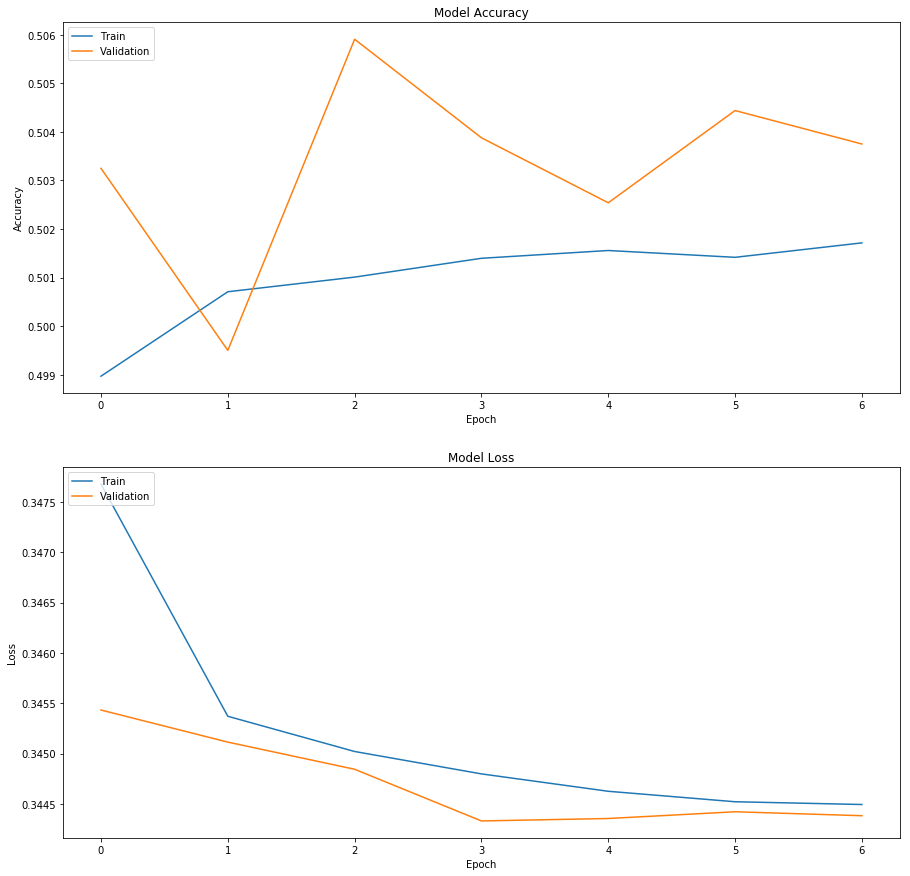

In [16]:
train_hist_plot(base_history, "model_final_base_train_perf")

In [17]:
model_metrics(model_final_base, X_test_scaled, y_test)

[[157113  20157   5965      0   1435   7054]
 [  7689  62215  12344      0   1099   6309]
 [ 17636  22754  29809      0   1381  20993]
 [  3841   9841  10973      0    543   8957]
 [ 26851  10917  12295      0   1998   8925]
 [  9025  16784  19642      0   1122  16684]]
AUC: 0.782418685164592
532351/532351 [==============================] - 5s 9us/step
Test score: 0.34452447510195167
Test accuracy: 0.5030872488255365


## Model 2

In [18]:
# Instatiate a Sequential model
model_final2 = Sequential()

# Create a basic network
model_final2.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final2.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [19]:
final2_checkpoint_path, final2_history = fit_save_model(model_final2, 'model_final2', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3496 - categorical_accuracy: 0.4989 - val_loss: 0.3457 - val_categorical_accuracy: 0.5046

Epoch 00001: val_loss improved from inf to 0.34572, saving model to model_final/model_final2.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3455 - categorical_accuracy: 0.5009 - val_loss: 0.3452 - val_categorical_accuracy: 0.5012

Epoch 00002: val_loss improved from 0.34572 to 0.34522, saving model to model_final/model_final2.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3450 - categorical_accuracy: 0.5014 - val_loss: 0.3449 - val_categorical_accuracy: 0.4993

Epoch 00003: val_loss improved from 0.34522 to 0.34492, saving model to model_final/model_final2.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3448 - categorical_accuracy:

In [20]:
# Load best model to save training time
model_final2 = keras.models.load_model(final2_checkpoint_path)

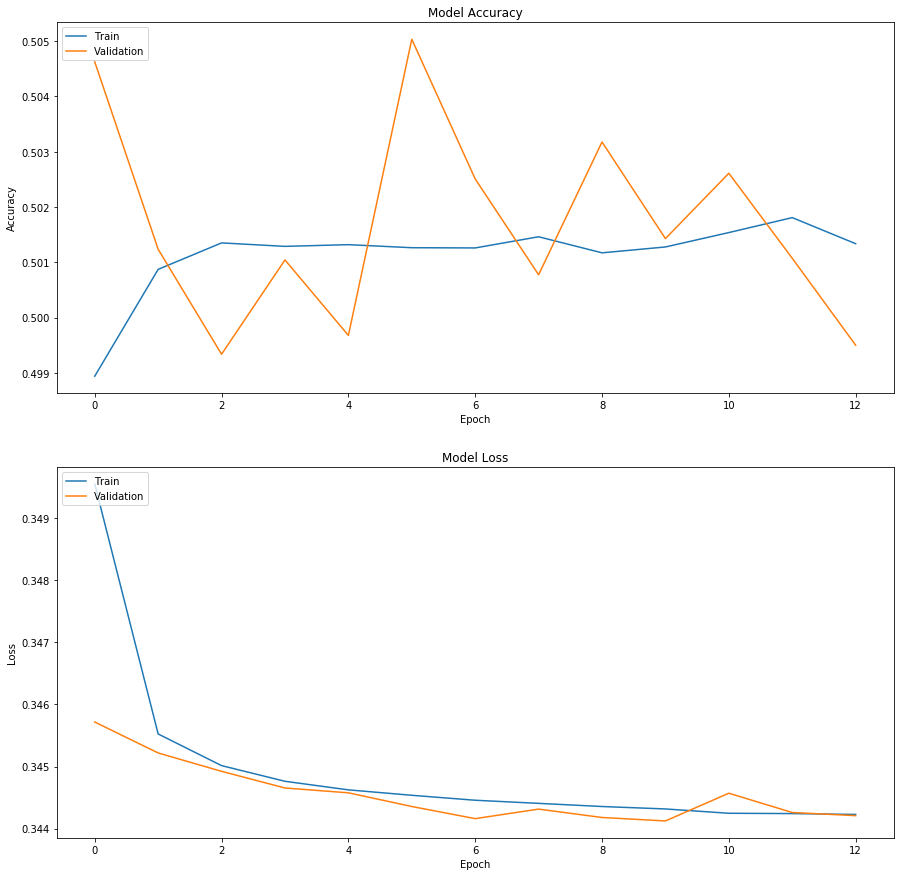

In [21]:
train_hist_plot(final2_history, "model_final2_train_perf")

In [22]:
model_metrics(model_final2, X_test_scaled, y_test)

[[155755  22243   5480      0   1267   6979]
 [  6329  65220  10494      0    928   6685]
 [ 17519  24527  24762      0   1184  24581]
 [  3795  10490   9181      0    434  10255]
 [ 26551  11883  10865      0   1758   9929]
 [  8897  17947  16579      0    860  18974]]
AUC: 0.7826086988695934
532351/532351 [==============================] - 5s 9us/step
Test score: 0.3443629500227517
Test accuracy: 0.5005513279763223


## Model 3

In [23]:
# Instatiate a Sequential model
model_final3 = Sequential()

# Create a basic network
model_final3.add(Dense(50, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final3.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final3.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [24]:
final3_checkpoint_path, final3_history = fit_save_model(model_final3, 'model_final3', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 31s 26us/step - loss: 0.3495 - categorical_accuracy: 0.4979 - val_loss: 0.3462 - val_categorical_accuracy: 0.4990

Epoch 00001: val_loss improved from inf to 0.34619, saving model to model_final/model_final3.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3461 - categorical_accuracy: 0.4998 - val_loss: 0.3455 - val_categorical_accuracy: 0.5029

Epoch 00002: val_loss improved from 0.34619 to 0.34552, saving model to model_final/model_final3.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3456 - categorical_accuracy: 0.5004 - val_loss: 0.3452 - val_categorical_accuracy: 0.5013

Epoch 00003: val_loss improved from 0.34552 to 0.34523, saving model to model_final/model_final3.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3454 - categorical_accuracy:

In [25]:
# Load best model to save training time
model_final3 = keras.models.load_model(final3_checkpoint_path)

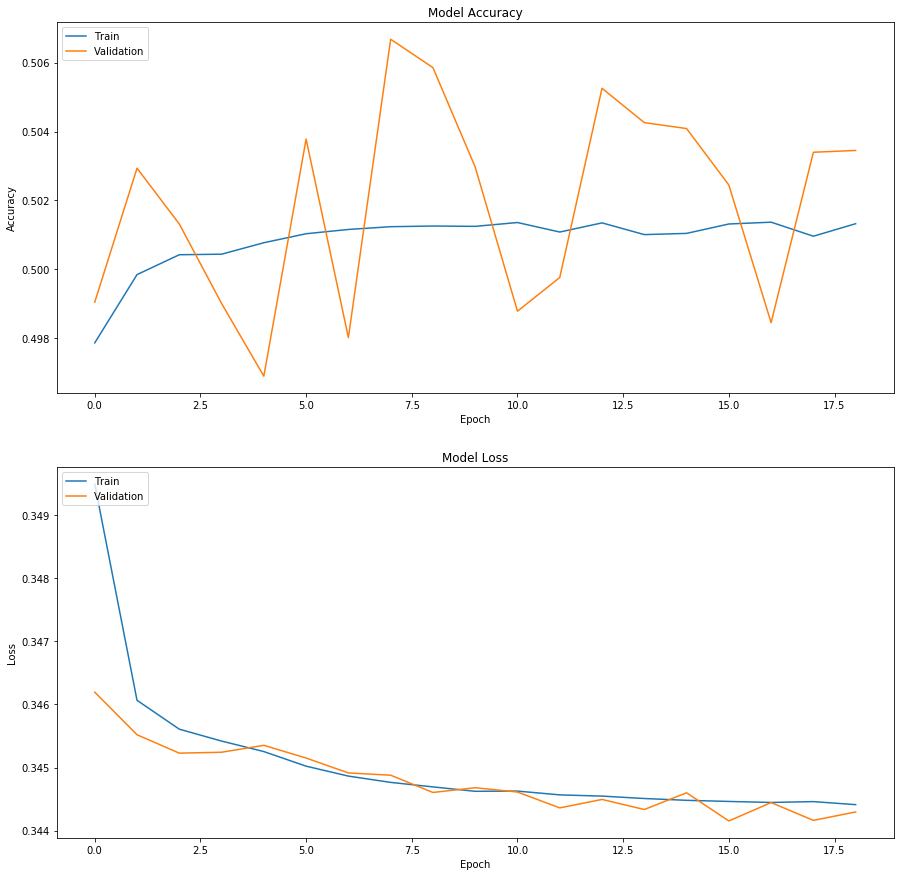

In [26]:
train_hist_plot(final3_history, "model_final3_train_perf")

In [27]:
model_metrics(model_final3, X_test_scaled, y_test)

[[158792  19235   4176      0   1240   8281]
 [  9663  62647   8432      0    800   8114]
 [ 18547  24220  22830      0   1415  25561]
 [  4221  10546   7676      0    597  11115]
 [ 27280  11464   9017      0   2015  11210]
 [  9738  17950  13966      0   1186  20417]]
AUC: 0.7823748374158158
532351/532351 [==============================] - 5s 10us/step
Test score: 0.34444953554561814
Test accuracy: 0.5009871306704095


## Model 4

In [28]:
# Instatiate a Sequential model
model_final4 = Sequential()

# Create a basic network
model_final4.add(Dense(300, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final4.add(Dropout(0.5))
model_final4.add(Dense(100, activation = 'relu'))
model_final4.add(Dropout(0.5))
model_final4.add(Dense(100, activation = 'relu'))
model_final4.add(Dropout(0.5))
model_final4.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [29]:
final4_checkpoint_path, final4_history = fit_save_model(model_final4, 'model_final4', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 89s 75us/step - loss: 0.3602 - categorical_accuracy: 0.4866 - val_loss: 0.3492 - val_categorical_accuracy: 0.5001

Epoch 00001: val_loss improved from inf to 0.34923, saving model to model_final/model_final4.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 87s 73us/step - loss: 0.3564 - categorical_accuracy: 0.4899 - val_loss: 0.3470 - val_categorical_accuracy: 0.4966

Epoch 00002: val_loss improved from 0.34923 to 0.34696, saving model to model_final/model_final4.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 86s 72us/step - loss: 0.3560 - categorical_accuracy: 0.4901 - val_loss: 0.3482 - val_categorical_accuracy: 0.4943

Epoch 00003: val_loss did not improve from 0.34696
Epoch 4/25
1197789/1197789 [==============================] - 87s 73us/step - loss: 0.3559 - categorical_accuracy: 0.4902 - val_loss: 0.3473 - val_categorical_accura

In [30]:
# Load best model to save training time
model_final4 = keras.models.load_model(final4_checkpoint_path)

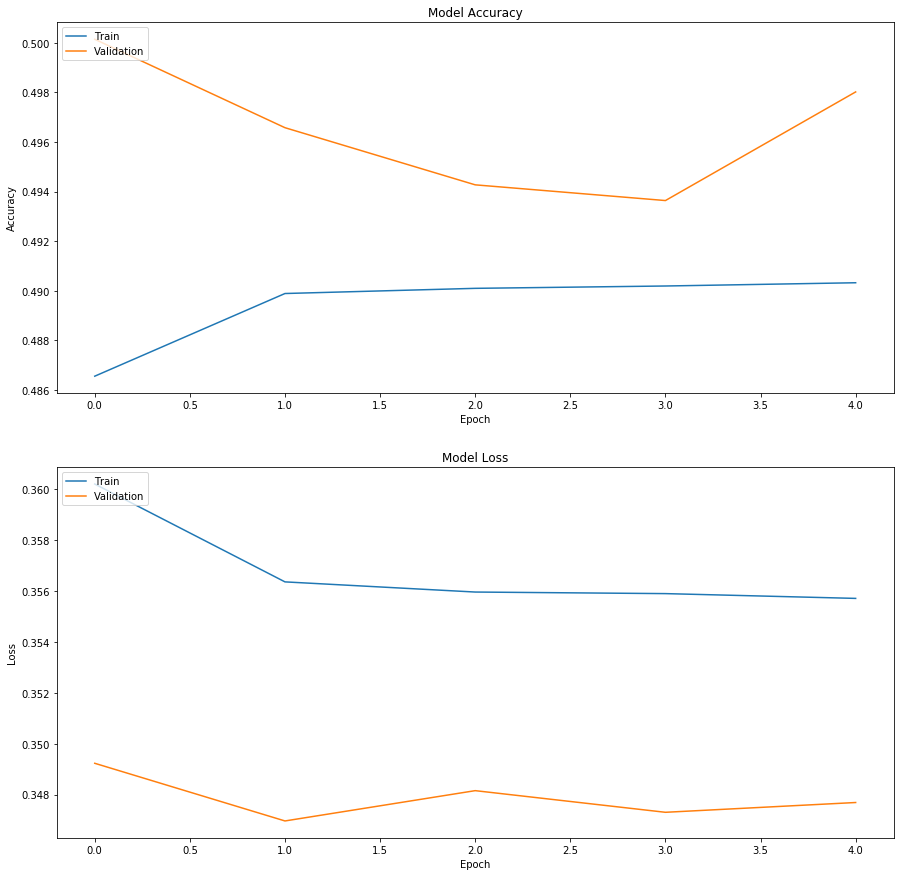

In [31]:
train_hist_plot(final4_history, "model_final4_train_perf")

In [32]:
model_metrics(model_final4, X_test_scaled, y_test)

[[155033  23815   4835      0    535   7506]
 [  5727  67374   8978      0    233   7344]
 [ 17422  26716  20027      0    526  27882]
 [  3705  11304   7675      0    209  11262]
 [ 27013  13095   8951      0    621  11306]
 [  8791  19369  13639      0    504  20954]]
AUC: 0.7780245160323146
532351/532351 [==============================] - 8s 16us/step
Test score: 0.3471530497693629
Test accuracy: 0.4959303166509757


## Model 5

In [33]:
# Instatiate a Sequential model
model_final5 = Sequential()

# Create a basic network
model_final5.add(Dense(100, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final5.add(Dropout(0.5))
model_final5.add(Dense(100, activation = 'tanh'))
model_final5.add(Dropout(0.5))
model_final5.add(Dense(100, activation = 'tanh'))
model_final5.add(Dropout(0.5))
model_final5.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final5.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [34]:
final5_checkpoint_path, final5_history = fit_save_model(model_final5, 'model_final5', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 67s 56us/step - loss: 0.3626 - categorical_accuracy: 0.4861 - val_loss: 0.3491 - val_categorical_accuracy: 0.4988

Epoch 00001: val_loss improved from inf to 0.34907, saving model to model_final/model_final5.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 64s 54us/step - loss: 0.3560 - categorical_accuracy: 0.4910 - val_loss: 0.3490 - val_categorical_accuracy: 0.4961

Epoch 00002: val_loss improved from 0.34907 to 0.34904, saving model to model_final/model_final5.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 69s 58us/step - loss: 0.3556 - categorical_accuracy: 0.4907 - val_loss: 0.3486 - val_categorical_accuracy: 0.5029

Epoch 00003: val_loss improved from 0.34904 to 0.34859, saving model to model_final/model_final5.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 68s 57us/step - loss: 0.3554 - categorical_accuracy:

In [35]:
# Load best model to save training time
model_final5 = keras.models.load_model(final5_checkpoint_path)

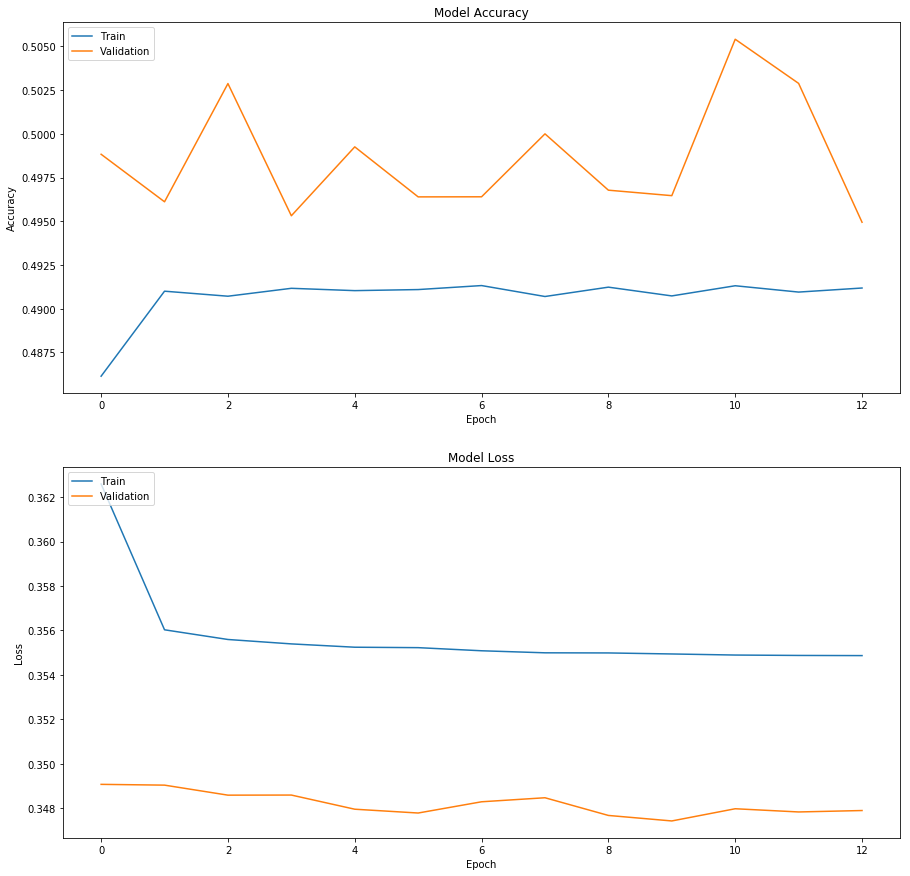

In [36]:
train_hist_plot(final5_history, "model_final5_train_perf")

In [37]:
model_metrics(model_final5, X_test_scaled, y_test)

[[153790  22011   5704      0   2494   7725]
 [  5076  64914  10310      0   1627   7729]
 [ 16432  24298  19328      0   2675  29840]
 [  3412  10402   7115      0   1107  12119]
 [ 25276  12556   8111      0   3288  11755]
 [  8043  17760  12782      0   2317  22355]]
AUC: 0.7779210637169477
532351/532351 [==============================] - 9s 16us/step
Test score: 0.34768215830026133
Test accuracy: 0.4953029110500727


## Model 6

In [38]:
# Instatiate a Sequential model
model_final6 = Sequential()

# Create a basic network
model_final6.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final6.add(Dropout(0.5))
model_final6.add(Dense(50, activation = 'tanh'))
model_final6.add(Dropout(0.5))
model_final6.add(Dense(50, activation = 'tanh'))
model_final6.add(Dropout(0.5))
model_final6.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final6.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [39]:
final6_checkpoint_path, final6_history = fit_save_model(model_final6, 'model_final6', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 50s 42us/step - loss: 0.3671 - categorical_accuracy: 0.4809 - val_loss: 0.3520 - val_categorical_accuracy: 0.4949

Epoch 00001: val_loss improved from inf to 0.35202, saving model to model_final/model_final6.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 48s 40us/step - loss: 0.3597 - categorical_accuracy: 0.4879 - val_loss: 0.3510 - val_categorical_accuracy: 0.4956

Epoch 00002: val_loss improved from 0.35202 to 0.35103, saving model to model_final/model_final6.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 48s 40us/step - loss: 0.3594 - categorical_accuracy: 0.4881 - val_loss: 0.3510 - val_categorical_accuracy: 0.5021

Epoch 00003: val_loss did not improve from 0.35103
Epoch 4/25
1197789/1197789 [==============================] - 49s 41us/step - loss: 0.3593 - categorical_accuracy: 0.4879 - val_loss: 0.3508 - val_categorical_accura

In [40]:
# Load best model to save training time
model_final6 = keras.models.load_model(final6_checkpoint_path)

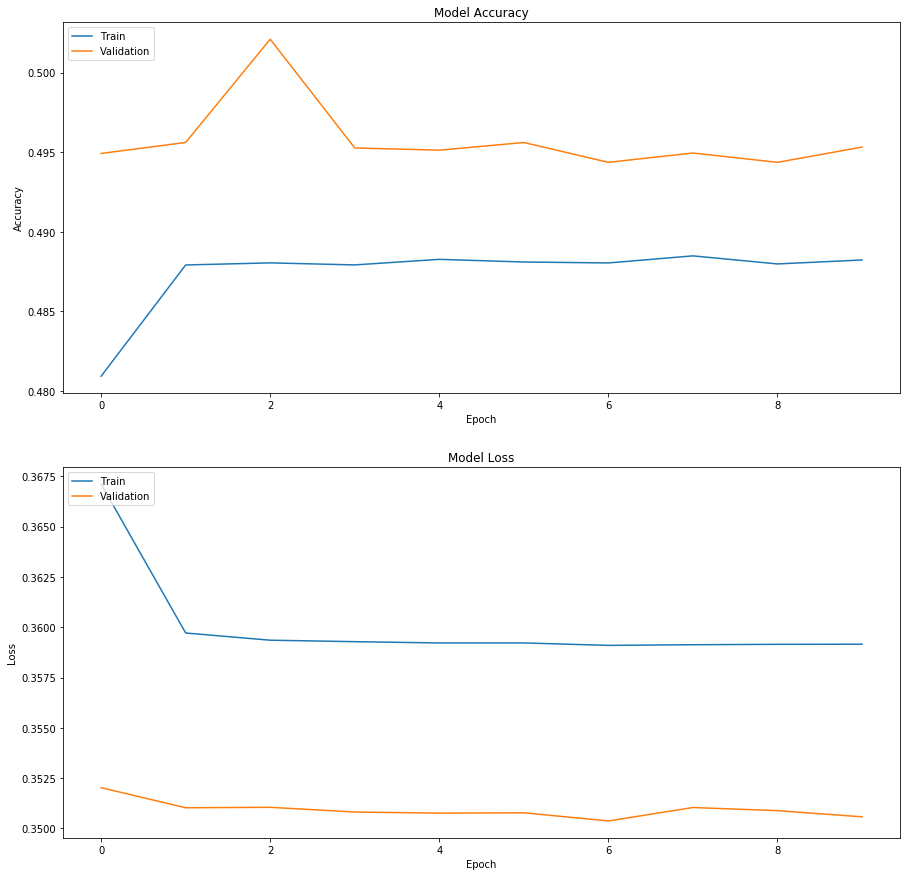

In [41]:
train_hist_plot(final6_history, "model_final6_train_perf")

In [42]:
model_metrics(model_final6, X_test_scaled, y_test)

[[155126  22215   5317      0   1264   7802]
 [  5986  65940   8807      0    746   8177]
 [ 17592  25713  17681      0   1197  30390]
 [  3848  10809   6704      0    456  12338]
 [ 26311  13470   7967      0   1422  11816]
 [  8967  18638  12052      0   1009  22591]]
AUC: 0.7727120493198981
532351/532351 [==============================] - 7s 13us/step
Test score: 0.3506632738473608
Test accuracy: 0.49358412025227194


## Model 7

In [43]:
# Instatiate a Sequential model
model_final7 = Sequential()

# Create a basic network
model_final7.add(Dense(25, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final7.add(Dropout(0.5))
model_final7.add(Dense(25, activation = 'tanh'))
model_final7.add(Dropout(0.5))
model_final7.add(Dense(25, activation = 'tanh'))
model_final7.add(Dropout(0.5))
model_final7.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final7.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [44]:
final7_checkpoint_path, final7_history = fit_save_model(model_final7, 'model_final7', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 46s 38us/step - loss: 0.3738 - categorical_accuracy: 0.4718 - val_loss: 0.3564 - val_categorical_accuracy: 0.4916

Epoch 00001: val_loss improved from inf to 0.35640, saving model to model_final/model_final7.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 48s 40us/step - loss: 0.3662 - categorical_accuracy: 0.4798 - val_loss: 0.3555 - val_categorical_accuracy: 0.4905

Epoch 00002: val_loss improved from 0.35640 to 0.35549, saving model to model_final/model_final7.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 44s 37us/step - loss: 0.3660 - categorical_accuracy: 0.4810 - val_loss: 0.3549 - val_categorical_accuracy: 0.4945

Epoch 00003: val_loss improved from 0.35549 to 0.35485, saving model to model_final/model_final7.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 44s 37us/step - loss: 0.3659 - categorical_accuracy:

In [45]:
# Load best model to save training time
model_final7 = keras.models.load_model(final7_checkpoint_path)

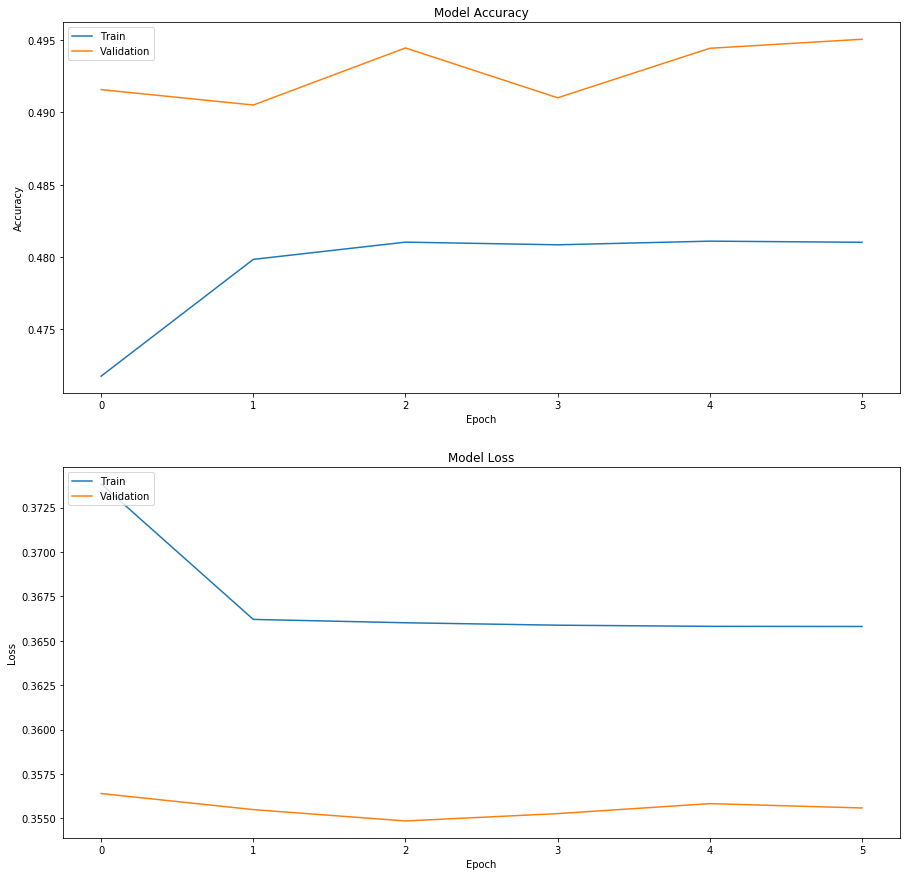

In [46]:
train_hist_plot(final7_history, "model_final7_train_perf")

In [47]:
model_metrics(model_final7, X_test_scaled, y_test)

[[155874  22014   6325      0      1   7510]
 [  6274  65598  10600      0      0   7184]
 [ 18050  25480  19890      0      5  29148]
 [  4008  10728   7778      0      0  11641]
 [ 27053  13348   8788      0      1  11796]
 [  9290  18469  14018      0      1  21479]]
AUC: 0.7616291734746651
532351/532351 [==============================] - 7s 13us/step
Test score: 0.3551199102487454
Test accuracy: 0.4937381539631131


## Model 8

In [48]:
# Instatiate a Sequential model
model_final8 = Sequential()

# Create a basic network
model_final8.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final8.add(Dropout(0.5))
model_final8.add(Dense(50, activation = 'relu'))
model_final8.add(Dropout(0.5))
model_final8.add(Dense(50, activation= 'relu'))
model_final8.add(Dropout(0.5))
model_final8.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final8.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [49]:
final8_checkpoint_path, final8_history = fit_save_model(model_final8, 'model_final8', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 56s 47us/step - loss: 0.3676 - categorical_accuracy: 0.4769 - val_loss: 0.3514 - val_categorical_accuracy: 0.4953

Epoch 00001: val_loss improved from inf to 0.35140, saving model to model_final/model_final8.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 50s 42us/step - loss: 0.3606 - categorical_accuracy: 0.4834 - val_loss: 0.3506 - val_categorical_accuracy: 0.4923

Epoch 00002: val_loss improved from 0.35140 to 0.35059, saving model to model_final/model_final8.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 51s 42us/step - loss: 0.3597 - categorical_accuracy: 0.4850 - val_loss: 0.3496 - val_categorical_accuracy: 0.4937

Epoch 00003: val_loss improved from 0.35059 to 0.34955, saving model to model_final/model_final8.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 53s 44us/step - loss: 0.3593 - categorical_accuracy:

In [50]:
# Load best model to save training time
model_final8 = keras.models.load_model(final8_checkpoint_path)

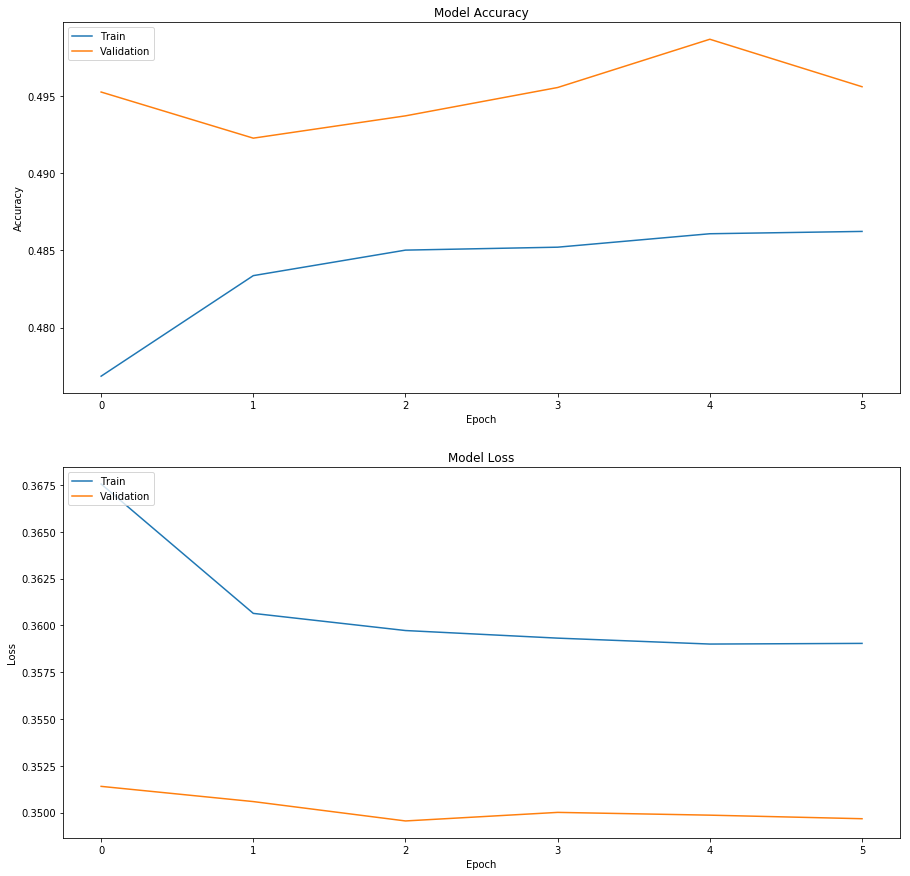

In [51]:
train_hist_plot(final8_history, "model_final8_train_perf")

In [52]:
model_metrics(model_final8, X_test_scaled, y_test)

[[155592  24611   4420      0      0   7101]
 [  6038  67199   9888      0      0   6531]
 [ 18053  27225  19837      0      0  27458]
 [  3875  11308   8204      0      0  10768]
 [ 28336  12908   8354      0      0  11388]
 [  9345  19446  14416      0      0  20050]]
AUC: 0.771075034014014
532351/532351 [==============================] - 8s 14us/step
Test score: 0.3496387355102682
Test accuracy: 0.49343008654143083


## Model 9

In [53]:
# Instatiate a Sequential model
model_final9 = Sequential()

# Create a basic network
model_final9.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final9.add(Dropout(0.2))
model_final9.add(Dense(50, activation = 'relu'))
model_final9.add(Dropout(0.2))
model_final9.add(Dense(50, activation = 'relu'))
model_final9.add(Dropout(0.2))
model_final9.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final9.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [54]:
final9_checkpoint_path, final9_history = fit_save_model(model_final9, 'model_final9', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 56s 47us/step - loss: 0.3543 - categorical_accuracy: 0.4922 - val_loss: 0.3465 - val_categorical_accuracy: 0.5012

Epoch 00001: val_loss improved from inf to 0.34646, saving model to model_final/model_final9.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 53s 44us/step - loss: 0.3498 - categorical_accuracy: 0.4955 - val_loss: 0.3455 - val_categorical_accuracy: 0.5011

Epoch 00002: val_loss improved from 0.34646 to 0.34551, saving model to model_final/model_final9.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 54s 45us/step - loss: 0.3493 - categorical_accuracy: 0.4959 - val_loss: 0.3450 - val_categorical_accuracy: 0.5031

Epoch 00003: val_loss improved from 0.34551 to 0.34502, saving model to model_final/model_final9.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 56s 46us/step - loss: 0.3492 - categorical_accuracy:

In [55]:
# Load best model to save training time
model_final9 = keras.models.load_model(final9_checkpoint_path)

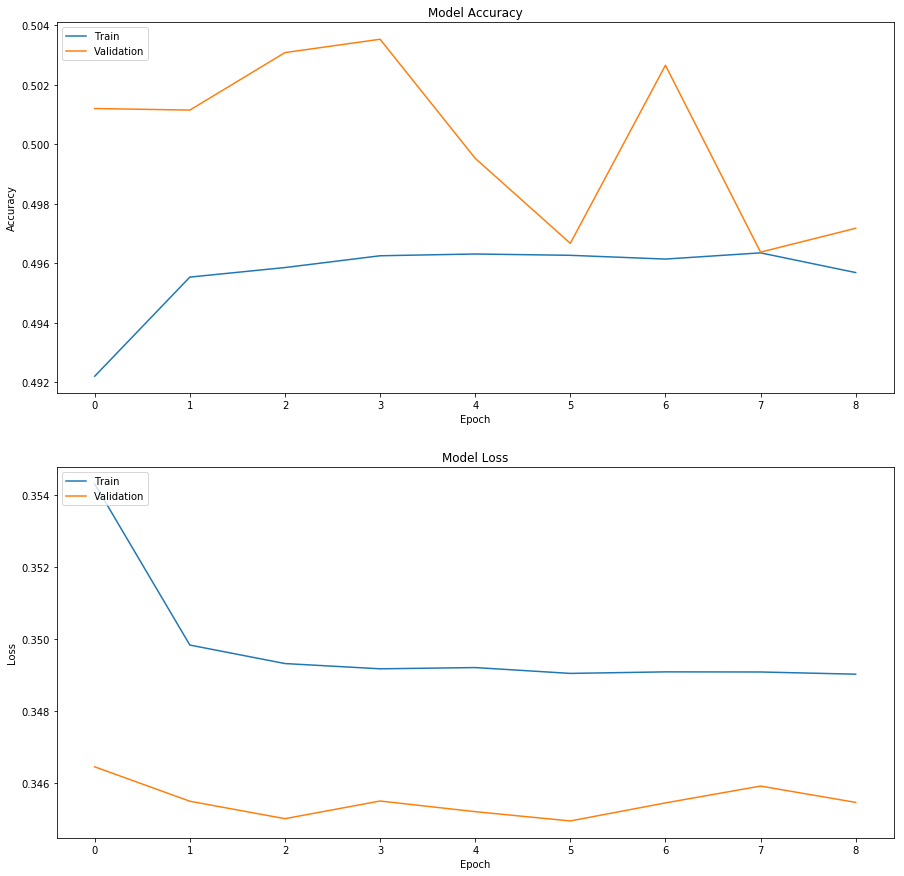

In [56]:
train_hist_plot(final9_history, "model_final9_train_perf")

In [57]:
model_metrics(model_final9, X_test_scaled, y_test)

[[156337  22174   4142      0   1203   7868]
 [  6831  66456   8040      0    574   7755]
 [ 17624  26403  17963      0   1124  29459]
 [  3778  11273   6772      0    429  11903]
 [ 27342  12282   7187      0   1500  12675]
 [  9002  19201  12096      0    966  21992]]
AUC: 0.7811422051179591
532351/532351 [==============================] - 7s 14us/step
Test score: 0.34514553049879737
Test accuracy: 0.496379268564281


## Model 10

In [58]:
# Instatiate a Sequential model
model_finalX = Sequential()

# Create a basic network
model_finalX.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_finalX.add(Dropout(0.3))
model_finalX.add(Dense(50, activation = 'relu'))
model_finalX.add(Dropout(0.3))
model_finalX.add(Dense(50, activation = 'relu'))
model_finalX.add(Dropout(0.3))
model_finalX.add(Dense(25, activation = 'relu'))
model_finalX.add(Dropout(0.3))
model_finalX.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalX.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [59]:
finalX_checkpoint_path, finalX_history = fit_save_model(model_finalX, 'model_finalX', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 60s 50us/step - loss: 0.3628 - categorical_accuracy: 0.4812 - val_loss: 0.3489 - val_categorical_accuracy: 0.4958

Epoch 00001: val_loss improved from inf to 0.34893, saving model to model_final/model_finalX.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 63s 52us/step - loss: 0.3565 - categorical_accuracy: 0.4872 - val_loss: 0.3491 - val_categorical_accuracy: 0.4974

Epoch 00002: val_loss did not improve from 0.34893
Epoch 3/25
1197789/1197789 [==============================] - 65s 54us/step - loss: 0.3560 - categorical_accuracy: 0.4880 - val_loss: 0.3498 - val_categorical_accuracy: 0.4966

Epoch 00003: val_loss did not improve from 0.34893
Epoch 4/25
1197789/1197789 [==============================] - 64s 53us/step - loss: 0.3559 - categorical_accuracy: 0.4883 - val_loss: 0.3481 - val_categorical_accuracy: 0.4959

Epoch 00004: val_loss improved from 0.3

In [60]:
# Load best model to save training time
model_finalX = keras.models.load_model(finalX_checkpoint_path)

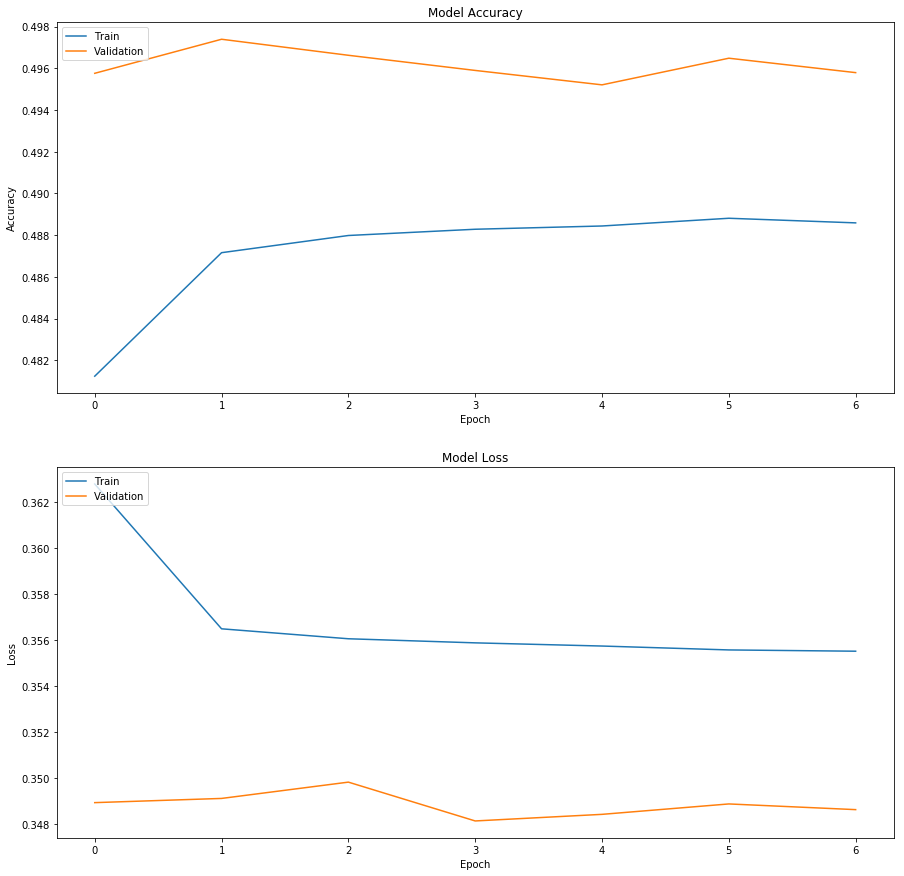

In [61]:
train_hist_plot(finalX_history, "model_finalX_train_perf")

In [62]:
model_metrics(model_finalX, X_test_scaled, y_test)

[[157312  21948   5655      0    310   6499]
 [  7817  67514   8024      0    152   6149]
 [ 17987  28852  18610      0    235  26889]
 [  3934  12174   7399      0     92  10556]
 [ 27298  13163   9269      0    378  10878]
 [  9247  20896  13318      0    188  19608]]
AUC: 0.7750967646476136
532351/532351 [==============================] - 8s 15us/step
Test score: 0.34818605798754376
Test accuracy: 0.4948276606966516
